# Event-Based Action Recognition: A Performance Evaluation of ConvLSTM and LRCN

A. Read the DVS data from aedat files and convert the files into videos

In [ ]:
import os
import cv2
import numpy as np
import struct

#Extracts DVS events from a Davis file.
def getDVSeventsDavis(file, numEvents=1e10, startTime=0):  
    print('\ngetDVSeventsDavis function called \n')
    
    # Constants for the Davis file format
    sizeX = 346
    sizeY = 260
    x0 = 0
    y0 = 0
    x1 = sizeX
    y1 = sizeY

    print('Reading in at most', str(numEvents))

    triggerevent = int('400', 16)
    polmask = int('800', 16)
    xmask = int('003FF000', 16)
    ymask = int('7FC00000', 16)
    typemask = int('80000000', 16)
    typedvs = int('00', 16)
    xshift = 12
    yshift = 22
    polshift = 11
    
    # Lists to store the events
    x = []
    y = []
    ts = []
    pol = []
    numeventsread = 0
    length = 0
    
    # Open the Davis file for reading
    aerdatafh = open(file, 'rb')
    k = 0
    p = 0
    statinfo = os.stat(file)
    if length == 0:
        length = statinfo.st_size
    print("file size", length)

    lt = aerdatafh.readline()
    while lt and str(lt)[2] == "#":
        p += len(lt)
        k += 1
        lt = aerdatafh.readline()
        continue

    # Read events from the file
    aerdatafh.seek(p)
    tmp = aerdatafh.read(8)
    p += 8
    while p < length:
        ad, tm = struct.unpack_from('>II', tmp)
        ad = abs(ad)
        if tm >= startTime:
            if (ad & typemask) == typedvs:
                xo = sizeX - 1 - float((ad & xmask) >> xshift)
                yo = float((ad & ymask) >> yshift)
                polo = 1 - float((ad & polmask) >> polshift)
                if xo >= x0 and xo < x1 and yo >= y0 and yo < y1:
                    x.append(xo)
                    y.append(yo)
                    pol.append(polo)
                    ts.append(tm)
        aerdatafh.seek(p)
        tmp = aerdatafh.read(8)
        p += 8
        numeventsread += 1

    print('Total number of events read =', numeventsread)
    print('Total number of DVS events returned =', len(ts))
    return ts, x, y, pol

#Processes a single .aedat file and saves the events as a video.
def process_single_aedat(inputfile, output_folder):
    ts, x, y, pol = getDVSeventsDavis(inputfile)
    if not ts:
        print(f"No events found in {inputfile}. Skipping video processing.")
        return

    T = np.array(ts).reshape((-1, 1))
    X = np.array(x).reshape((-1, 1))
    Y = np.array(y).reshape((-1, 1))
    Pol = np.array(pol).reshape((-1, 1))
    step_time = 10000  # Time duration of each frame in the video
    start_idx = 0
    end_idx = 0
    start_time = T[0]
    end_time = start_time + step_time
    img_count = 0

    # Video settings
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fps = 30  # Frames per second
    filename = os.path.splitext(os.path.basename(inputfile))[0]
    video_output = cv2.VideoWriter(f'{output_folder}/{filename}.avi', fourcc, fps, (346, 260), isColor=False)

     # Process events and save them as frames in the video
    while end_time <= T[-1]:
        while T[end_idx] < end_time:
            end_idx = end_idx + 1

        data_x = np.array(X[start_idx:end_idx]).reshape((-1, 1))
        data_y = np.array(Y[start_idx:end_idx]).reshape((-1, 1))
        data_T = np.array(T[start_idx:end_idx]).reshape((-1, 1))
        data = np.column_stack((data_x, data_y)).astype(np.int32)

        timestamp = start_time * np.ones((260, 346))

        for i in range(0, data.shape[0]):
            timestamp[data[i, 1], data[i, 0]] = data_T[i]

        grayscale = np.flip(255 * (timestamp - start_time) / step_time, 0).astype(np.uint8)
        video_output.write(grayscale)

        start_time = end_time
        end_time += step_time
        start_idx = end_idx
        img_count += 1

    # Release the video writer and close the OpenCV windows
    video_output.release()
    cv2.destroyAllWindows()


if __name__ == '__main__':
    input_folder = 'C:/Hrishikesh/Meng_IoT/Project/Dataset/OneDrive_1_8-12-2023'
    output_folder = 'C:/Hrishikesh/Meng_IoT/Project/Dataset/videos'

    # List all action folders
    action_folders = ['jumping', 'kicking', 'throwing', 'picking up', 'waving', 'walking', 'turning around', 'sit-down', 'get-up', 'arm crossing']

    for action in action_folders:
        action_path = os.path.join(input_folder, action)
        output_action_path = os.path.join(output_folder, action)
        os.makedirs(output_action_path, exist_ok=True)

        # List all .aedat files in the action folder
        files = [file for file in os.listdir(action_path) if file.endswith('.aedat')]

        for file in files:
            inputfile = os.path.join(action_path, file)
            process_single_aedat(inputfile, output_action_path)

    print("Processing completed.")


B. Extract essential fram from the code and create a dataset

Extracting Data of Class: jumping
Extracting Data of Class: kicking
Extracting Data of Class: throwing
Extracting Data of Class: picking up
Extracting Data of Class: waving
Extracting Data of Class: walking
Extracting Data of Class: turning around
Extracting Data of Class: sit-down
Extracting Data of Class: get-up
Extracting Data of Class: arm crossing
Class: jumping | Number of Sequences: 21 | Total Frames: 1050
Class: kicking | Number of Sequences: 30 | Total Frames: 1500
Class: throwing | Number of Sequences: 30 | Total Frames: 1500
Class: picking up | Number of Sequences: 30 | Total Frames: 1500
Class: waving | Number of Sequences: 29 | Total Frames: 1450
Class: walking | Number of Sequences: 30 | Total Frames: 1500
Class: turning around | Number of Sequences: 30 | Total Frames: 1500
Class: sit-down | Number of Sequences: 30 | Total Frames: 1500
Class: get-up | Number of Sequences: 30 | Total Frames: 1500
Class: arm crossing | Number of Sequences: 30 | Total Frames: 1500


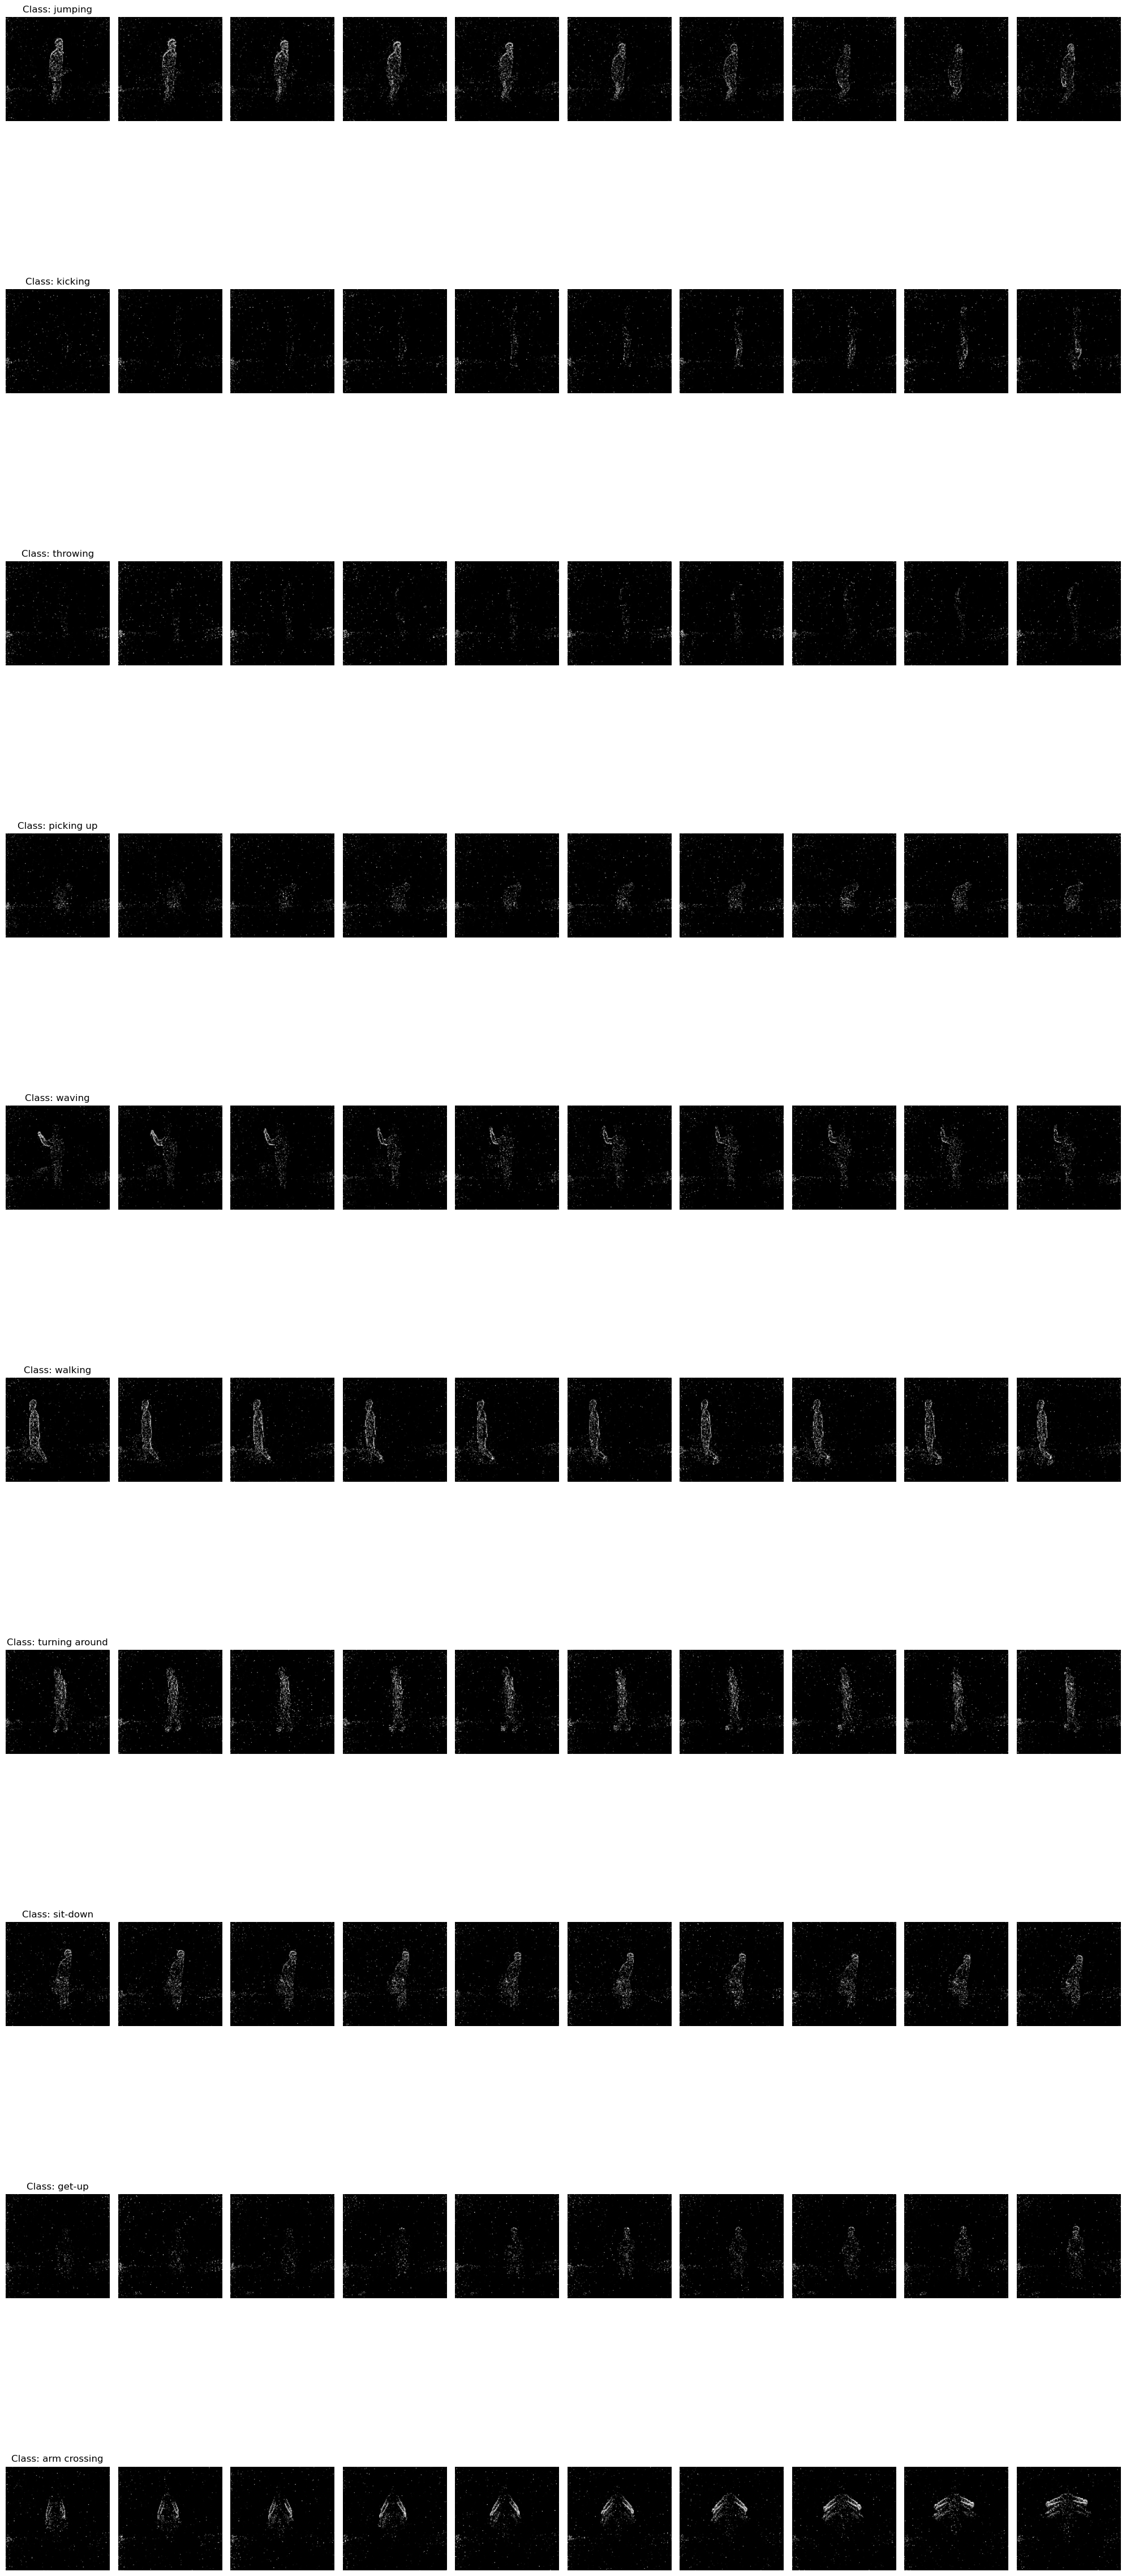

In [1]:
import cv2
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random

# Define constants
DATASET_DIR = "C:\\Hrishikesh\\Meng_IoT\\Project\\Dataset\\videos"
CLASSES_LIST = ['jumping', 'kicking', 'throwing', 'picking up', 'waving', 'walking', 'turning around', 'sit-down', 'get-up', 'arm crossing']
IMAGE_HEIGHT=140
IMAGE_WIDTH=140
SEQUENCE_LENGTH=50
SKIP_LAST_FRAMES=50
FRAMES_BEFORE_SKIP=100

def extract_frames(video_path, IMAGE_HEIGHT=IMAGE_HEIGHT, IMAGE_WIDTH=IMAGE_WIDTH, 
                   SEQUENCE_LENGTH=SEQUENCE_LENGTH, SKIP_LAST_FRAMES=SKIP_LAST_FRAMES, 
                   FRAMES_BEFORE_SKIP=FRAMES_BEFORE_SKIP):
    
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # If video has less than 150 frames, return an empty list
    if video_frames_count < (SKIP_LAST_FRAMES + FRAMES_BEFORE_SKIP):
        return frames_list
    
    start_frame = video_frames_count - SKIP_LAST_FRAMES - FRAMES_BEFORE_SKIP
    skip_frames_window = max(int(FRAMES_BEFORE_SKIP/SEQUENCE_LENGTH), 1)
    
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, start_frame + frame_counter * skip_frames_window)
        success, frame = video_reader.read() 
        if not success:
            break
        grayscale_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        resized_frame = cv2.resize(grayscale_frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame[..., np.newaxis] / 255.0

        frames_list.append(normalized_frame)
    video_reader.release()
    return frames_list

def create_dataset():
    features = []
    labels = []
    video_files_paths = []
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = extract_frames(video_file_path)
            
            # If frames list is not empty and its length is equal to SEQUENCE_LENGTH, append the data
            if frames and len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
                
    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels, video_files_paths

# Create the dataset.
features, labels, video_files_paths = create_dataset()

def display_frames_from_each_class(features, labels, video_files_paths, num_frames=10):
    plt.figure(figsize=(20, 5 * len(CLASSES_LIST)))
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        # Get indices for the current class
        class_indices = [i for i, label in enumerate(labels) if label == class_index]
        
        # Print the number of sequences and frames for the current class
        print(f"Class: {class_name} | Number of Sequences: {len(class_indices)} | Total Frames: {len(class_indices) * SEQUENCE_LENGTH}")
        
        # Randomly select a sequence from the current class
        random_sequence_idx = random.choice(class_indices)
        
        # Plot 10 frames from the selected sequence
        for frame_idx in range(num_frames):
            plt.subplot(len(CLASSES_LIST), num_frames, class_index * num_frames + frame_idx + 1)
            plt.imshow(features[random_sequence_idx][frame_idx].squeeze(), cmap='gray')
            
            # Set title for the first frame
            if frame_idx == 0:
                plt.title(f"Class: {class_name}")
            
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display 10 frames from a random sequence for each class
display_frames_from_each_class(features, labels, video_files_paths, num_frames=10)


C. Split the data into Training and Testing data

In [2]:
from sklearn.model_selection import train_test_split

# Split the data using integer labels
seed_constant = 23  
features_train, features_test, labels_train_int, labels_test_int = train_test_split(features, labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

# One-hot encode the labels for training and testing sets
labels_train = to_categorical(labels_train_int)
labels_test = to_categorical(labels_test_int)

# Count the number of sequences in each class for the training data
sequences_per_class_train = np.bincount(labels_train_int)
sequences_per_class_test = np.bincount(labels_test_int)

# Print the number of sequences for each class in training and testing data
print("Number of sequences per class in training data:")
for class_index, class_name in enumerate(CLASSES_LIST):
    print(f"Class: {class_name} | Sequences: {sequences_per_class_train[class_index]}")

print("\nNumber of sequences per class in testing data:")
for class_index, class_name in enumerate(CLASSES_LIST):
    print(f"Class: {class_name} | Sequences: {sequences_per_class_test[class_index]}")


Number of sequences per class in training data:
Class: jumping | Sequences: 16
Class: kicking | Sequences: 24
Class: throwing | Sequences: 20
Class: picking up | Sequences: 21
Class: waving | Sequences: 22
Class: walking | Sequences: 19
Class: turning around | Sequences: 23
Class: sit-down | Sequences: 21
Class: get-up | Sequences: 26
Class: arm crossing | Sequences: 25

Number of sequences per class in testing data:
Class: jumping | Sequences: 5
Class: kicking | Sequences: 6
Class: throwing | Sequences: 10
Class: picking up | Sequences: 9
Class: waving | Sequences: 7
Class: walking | Sequences: 11
Class: turning around | Sequences: 7
Class: sit-down | Sequences: 9
Class: get-up | Sequences: 4
Class: arm crossing | Sequences: 5


D. Define the model architecture for LRCN

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense

def create_LRCN_model():

    # Sequential model for model construction.
    model = Sequential()
    
    # Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
                              input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 1)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

# Create the LRCN model
LRCN_model = create_LRCN_model()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 50, 140, 140, 16   160       
 ributed)                    )                                   
                                                                 
 time_distributed_1 (TimeDi  (None, 50, 35, 35, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 50, 35, 35, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 50, 35, 35, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 50, 8, 8, 32)      0

E. Compile and train the model and plot the 'Loss vs Accuracy' graphs 

Epoch 1/70
7/7 [==============================] - 30s 3s/step - loss: 2.3170 - accuracy: 0.0829 - val_loss: 2.3065 - val_accuracy: 0.1096
Epoch 2/70
7/7 [==============================] - 21s 3s/step - loss: 2.2958 - accuracy: 0.1382 - val_loss: 2.3000 - val_accuracy: 0.0822
Epoch 3/70
7/7 [==============================] - 21s 3s/step - loss: 2.2864 - accuracy: 0.1797 - val_loss: 2.2912 - val_accuracy: 0.1507
Epoch 4/70
7/7 [==============================] - 20s 3s/step - loss: 2.2610 - accuracy: 0.1935 - val_loss: 2.2597 - val_accuracy: 0.1781
Epoch 5/70
7/7 [==============================] - 20s 3s/step - loss: 2.1991 - accuracy: 0.2350 - val_loss: 2.1271 - val_accuracy: 0.2603
Epoch 6/70
7/7 [==============================] - 20s 3s/step - loss: 2.1145 - accuracy: 0.2581 - val_loss: 2.0709 - val_accuracy: 0.3151
Epoch 7/70
7/7 [==============================] - 20s 3s/step - loss: 2.0071 - accuracy: 0.3364 - val_loss: 1.8847 - val_accuracy: 0.4932
Epoch 8/70
7/7 [==================

7/7 [==============================] - 19s 3s/step - loss: 0.3258 - accuracy: 0.9078 - val_loss: 0.7561 - val_accuracy: 0.7945
Epoch 61/70
7/7 [==============================] - 19s 3s/step - loss: 0.3617 - accuracy: 0.8710 - val_loss: 0.8436 - val_accuracy: 0.7671
Epoch 62/70
7/7 [==============================] - 20s 3s/step - loss: 0.3211 - accuracy: 0.8986 - val_loss: 0.9384 - val_accuracy: 0.7260
Epoch 63/70
7/7 [==============================] - 19s 3s/step - loss: 0.2581 - accuracy: 0.9263 - val_loss: 0.7250 - val_accuracy: 0.8219
Epoch 64/70
7/7 [==============================] - 19s 3s/step - loss: 0.2548 - accuracy: 0.9401 - val_loss: 0.7634 - val_accuracy: 0.7534
Epoch 65/70
7/7 [==============================] - 19s 3s/step - loss: 0.2173 - accuracy: 0.9585 - val_loss: 0.6878 - val_accuracy: 0.7671
Epoch 66/70
7/7 [==============================] - 19s 3s/step - loss: 0.2108 - accuracy: 0.9631 - val_loss: 0.6708 - val_accuracy: 0.8082
Epoch 67/70
7/7 [======================

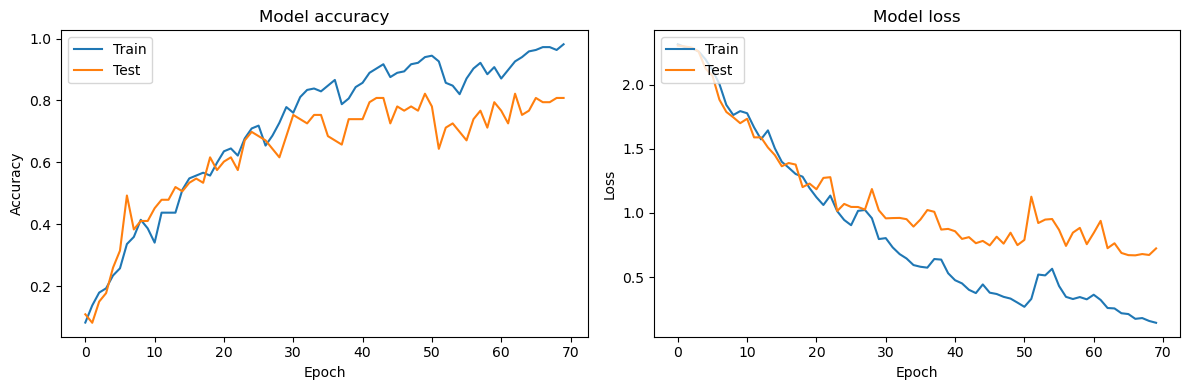

In [5]:
# Compile the model
LRCN_model.compile(optimizer='adam', 
                   loss='categorical_crossentropy', 
                   metrics=['accuracy'])

# Train the model
history = LRCN_model.fit(features_train, labels_train,
                         validation_data=(features_test, labels_test),
                         epochs=70,  # You can adjust the number of epochs
                         batch_size=32)  # You can adjust the batch size

# Plot the training history (Optional)
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
F. Generate the classification report

In [6]:
from sklearn.metrics import classification_report
import numpy as np

# labels for the test set
predicted_labels = LRCN_model.predict(features_test)

predicted_class_indices = np.argmax(predicted_labels, axis=1)
true_class_indices = np.argmax(labels_test, axis=1)

# Generate the classification report
report = classification_report(true_class_indices, predicted_class_indices, target_names=CLASSES_LIST)

print(report)


3/3 [==============================] - 2s 389ms/step
                precision    recall  f1-score   support

       jumping       1.00      0.60      0.75         5
       kicking       1.00      0.83      0.91         6
      throwing       0.75      0.60      0.67        10
    picking up       0.70      0.78      0.74         9
        waving       0.71      0.71      0.71         7
       walking       0.91      0.91      0.91        11
turning around       0.86      0.86      0.86         7
      sit-down       0.90      1.00      0.95         9
        get-up       0.67      1.00      0.80         4
  arm crossing       0.67      0.80      0.73         5

      accuracy                           0.81        73
     macro avg       0.82      0.81      0.80        73
  weighted avg       0.82      0.81      0.81        73



G. Define the model architecture for ConvLSTM

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout, Flatten, Dense

def create_convlstm_model():
    
    model = Sequential()

    # ConvLSTM Layers
    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True, 
                         input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 1)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    
    model.add(Flatten()) 
    
    # Final Dense Layer with Dropout for regularization
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(len(CLASSES_LIST), activation="softmax"))
     
    model.summary()
    
    return model

convlstm_model = create_convlstm_model()
print("Model Created Successfully!")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 50, 138, 138, 4)   736       
                                                                 
 max_pooling3d (MaxPooling3  (None, 50, 69, 69, 4)     0         
 D)                                                              
                                                                 
 time_distributed_12 (TimeD  (None, 50, 69, 69, 4)     0         
 istributed)                                                     
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 50, 67, 67, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 50, 34, 34, 8)     0         
 g3D)                                                            
                                                      

H. Compile and train the model and plot the 'Loss vs Accuracy' graphs

Epoch 1/30
14/14 [==============================] - 323s 22s/step - loss: 2.3345 - accuracy: 0.0968 - val_loss: 2.3014 - val_accuracy: 0.0822 - lr: 0.0010
Epoch 2/30
14/14 [==============================] - 305s 22s/step - loss: 2.3024 - accuracy: 0.1429 - val_loss: 2.3000 - val_accuracy: 0.1507 - lr: 0.0010
Epoch 3/30
14/14 [==============================] - 304s 22s/step - loss: 2.2781 - accuracy: 0.1521 - val_loss: 2.1592 - val_accuracy: 0.2329 - lr: 0.0010
Epoch 4/30
14/14 [==============================] - 307s 22s/step - loss: 2.1759 - accuracy: 0.1659 - val_loss: 2.0629 - val_accuracy: 0.2055 - lr: 0.0010
Epoch 5/30
14/14 [==============================] - 307s 22s/step - loss: 1.9088 - accuracy: 0.2627 - val_loss: 1.6543 - val_accuracy: 0.4658 - lr: 0.0010
Epoch 6/30
14/14 [==============================] - 310s 22s/step - loss: 1.7587 - accuracy: 0.3594 - val_loss: 1.5518 - val_accuracy: 0.5753 - lr: 0.0010
Epoch 7/30
14/14 [==============================] - 317s 22s/step - lo

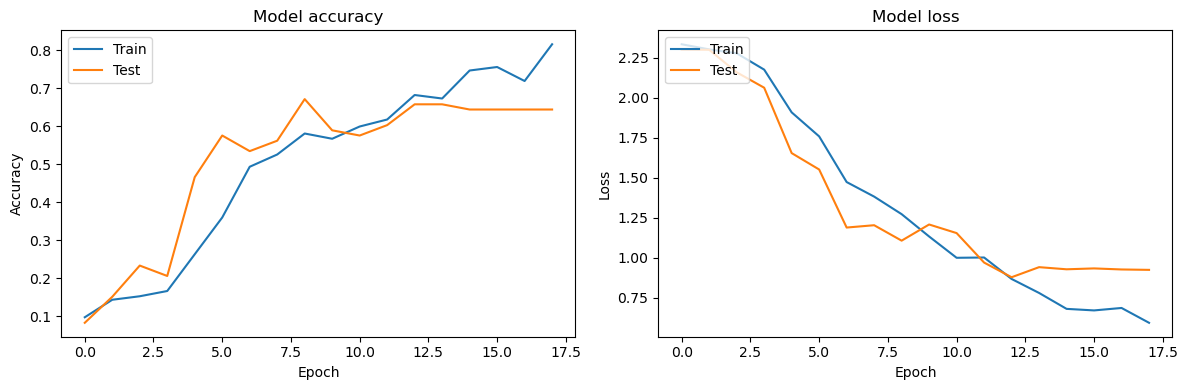

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Compile the model
optimizer = Adam(learning_rate=0.001)
convlstm_model.compile(optimizer=optimizer, 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.00001)

# Train the model
batch_size = 16
epochs = 30 

history = convlstm_model.fit(features_train, labels_train,
                             validation_data=(features_test, labels_test),
                             batch_size=batch_size,
                             epochs=epochs,
                             verbose=1,
                             callbacks=[early_stopping, reduce_lr_on_plateau])

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
I. Generate the classification report

In [11]:
from sklearn.metrics import classification_report
import numpy as np

# Predict the labels for the test set
predicted_labels = convlstm_model.predict(features_test)

# Convert the one-hot encoded predicted and true labels back to class indices
predicted_class_indices = np.argmax(predicted_labels, axis=1)
true_class_indices = np.argmax(labels_test, axis=1)

# Generate the classification report
report = classification_report(true_class_indices, predicted_class_indices, target_names=CLASSES_LIST)

print(report)


3/3 [==============================] - 14s 4s/step
                precision    recall  f1-score   support

       jumping       0.50      0.60      0.55         5
       kicking       0.40      0.67      0.50         6
      throwing       0.67      0.20      0.31        10
    picking up       0.75      0.67      0.71         9
        waving       0.50      0.86      0.63         7
       walking       0.86      0.55      0.67        11
turning around       0.75      0.86      0.80         7
      sit-down       0.88      0.78      0.82         9
        get-up       0.50      0.75      0.60         4
  arm crossing       1.00      1.00      1.00         5

      accuracy                           0.66        73
     macro avg       0.68      0.69      0.66        73
  weighted avg       0.70      0.66      0.65        73

